<a href="https://colab.research.google.com/github/LucianaGouv/atividades/blob/main/Cifar100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universidade Federal do Rio Grande do Norte
Disciplina: Projetos de Sistemas Baseados em Aprendizado de Máquina

Professor: Ivanovich

Aluna: Luciana Gouveia Machado

ATIVIDADE: Explorando Redes Neurais Convolucionais com PyTorch - CIFAR-100
---

## Objetivo da Atividade
Esta atividade tem como objetivo explorar **Redes Neurais Convolucionais (CNNs)** usando o dataset **CIFAR-100** do `torchvision.datasets`. Será mantida a arquitetura **LeNet-like** vista em aula, adaptando apenas o `in_channels` para 3 canais (RGB) e `out_features` para 100 classes.

## Checklist de Entrega:
- ✅ Escolher dataset **CIFAR-100** do `torchvision.datasets` (DIFERENTE do CIFAR-10 usado no artigo)
- ✅ Manter arquitetura LeNet-like adaptando `in_channels=3` (RGB) e 100 classes
- ✅ Treinar modelo e registrar métricas (loss e accuracy)
- ✅ Implementar hooks para capturar ativações intermediárias
- ✅ Visualizar feature maps de todas as camadas
- ✅ Escrever análise sobre observações

---

## Sobre o CIFAR-100
O **CIFAR-100** é similar ao CIFAR-10 mas possui **100 classes** ao invés de 10. Contém 60.000 imagens RGB (32x32 pixels) divididas em 50.000 para treino e 10.000 para teste, com 600 imagens por classe.

In [1]:
# ==== IMPORTS NECESSÁRIOS ====
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Configurar seed para reprodutibilidade
torch.manual_seed(42)
np.random.seed(42)

# Verificar GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'✓ Usando dispositivo: {device}')
print(f'✓ PyTorch versão: {torch.__version__}')
print(f'✓ Todos os imports carregados com sucesso!')

✓ Usando dispositivo: cuda
✓ PyTorch versão: 2.8.0+cu126
✓ Todos os imports carregados com sucesso!


In [2]:
# Carregar CIFAR-100 com transformações
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))  # Normalização CIFAR-100
])

train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f'✓ Treino: {len(train_dataset)} | Teste: {len(test_dataset)} | Batch: {batch_size} | Classes: 100')


100%|██████████| 169M/169M [00:03<00:00, 42.8MB/s]


✓ Treino: 50000 | Teste: 10000 | Batch: 128 | Classes: 100


In [3]:
# ==== ARQUITETURA LeNet-5 ADAPTADA PARA CIFAR-100 ====
# LeNet-5 adaptada: in_channels=3 (RGB), out_features=100 (100 classes)

# Definição da arquitetura usando nn.Sequential para simplificar
model = nn.Sequential(
    # === BLOCO CONVOLUCIONAL 1 ===
    # Conv2d(in_channels=3, out_channels=6, kernel_size=5)
    # - Entrada: imagens RGB 32x32x3
    # - Saída: 6 feature maps de 28x28 (32-5+1=28)
    # - Detecta características básicas (bordas, cores, texturas)
    nn.Conv2d(3, 6, 5),

    # ReLU: função de ativação não-linear
    # - Transforma valores negativos em zero
    # - Permite que a rede aprenda padrões complexos
    nn.ReLU(),

    # MaxPool2d(kernel_size=2, stride=2)
    # - Reduz dimensionalidade de 28x28 para 14x14
    # - Mantém as características mais importantes de cada região
    # - Torna a rede mais eficiente e robusta a pequenas variações
    nn.MaxPool2d(2, 2),

    # === BLOCO CONVOLUCIONAL 2 ===
    # Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    # - Entrada: 6 feature maps de 14x14
    # - Saída: 16 feature maps de 10x10 (14-5+1=10)
    # - Combina features do bloco anterior para detectar padrões mais complexos
    nn.Conv2d(6, 16, 5),

    # ReLU: ativação não-linear
    nn.ReLU(),

    # MaxPool2d: reduz de 10x10 para 5x5
    # - Consolida representações antes da classificação
    nn.MaxPool2d(2, 2),

    # === BLOCO CLASSIFICADOR ===
    # Flatten: transforma tensor 16x5x5 em vetor 1D de 400 elementos
    # - Prepara dados para as camadas fully connected
    nn.Flatten(),

    # Linear(in_features=400, out_features=120)
    # - Primeira camada densa: 16*5*5=400 -> 120
    # - Aprende combinações complexas das features extraídas
    nn.Linear(16*5*5, 120),
    nn.ReLU(),

    # Linear(120, 84): segunda camada densa
    # - Refina as representações aprendidas
    nn.Linear(120, 84),
    nn.ReLU(),

    # Linear(84, 100): camada de saída
    # - 100 neurônios, um para cada classe do CIFAR-100
    # - Os logits são convertidos em probabilidades pela CrossEntropyLoss
    nn.Linear(84, 100)
)

# Mover modelo para GPU se disponível
model = model.to(device)

# Exibir informações sobre o modelo
print(f'\n✓ Arquitetura LeNet-5 para CIFAR-100 criada')
print(f'✓ Parâmetros treináveis: {sum(p.numel() for p in model.parameters()):,}')


✓ Arquitetura LeNet-5 para CIFAR-100 criada
✓ Parâmetros treináveis: 69,656


In [4]:
# ==== TREINAMENTO DO MODELO ====
# Configurar função de perda e otimizador

# CrossEntropyLoss: função de perda para classificação multiclasse
# - Combina LogSoftmax + NLLLoss em uma única função
# - Calcula a diferença entre predições e labels verdadeiros
criterion = nn.CrossEntropyLoss()

# SGD (Stochastic Gradient Descent): otimizador para atualizar pesos
# - lr=0.001: taxa de aprendizado (controla tamanho dos passos)
# - momentum=0.9: acelera convergência e evita mínimos locais
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Listas para armazenar métricas durante treinamento
train_losses = []  # Loss de treino por época
train_accuracies = []  # Acurácia de treino por época
test_losses = []  # Loss de teste por época
test_accuracies = []  # Acurácia de teste por época

print('✅ Otimizador e função de perda configurados')
print(f'   - Loss: CrossEntropyLoss')
print(f'   - Optimizer: SGD (lr=0.001, momentum=0.9)')

✅ Otimizador e função de perda configurados
   - Loss: CrossEntropyLoss
   - Optimizer: SGD (lr=0.001, momentum=0.9)


In [5]:
# ==== LOOP DE TREINAMENTO ====
# Treinar por 24 épocas (ou menos para teste rápido)

num_epochs = 24  # Usar 5 épocas para teste rápido. Alterar para 20 para resultado completo
print(f'\n🚀 Iniciando treinamento por {num_epochs} épocas...')
print('='*70)

for epoch in range(num_epochs):
    # === FASE DE TREINO ===
    model.train()  # Coloca modelo em modo de treinamento
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterar sobre batches de treino
    for i, (inputs, labels) in enumerate(train_loader):
        # Mover dados para GPU se disponível
        inputs, labels = inputs.to(device), labels.to(device)

        # Zerar gradientes acumulados da iteração anterior
        optimizer.zero_grad()

        # Forward pass: calcular predições do modelo
        outputs = model(inputs)

        # Calcular loss (diferença entre predição e label real)
        loss = criterion(outputs, labels)

        # Backward pass: calcular gradientes
        loss.backward()

        # Atualizar pesos do modelo usando gradientes
        optimizer.step()

        # Acumular estatísticas para cálculo de métricas
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calcular métricas de treino
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # === FASE DE VALIDAÇÃO ===
    model.eval()  # Coloca modelo em modo de avaliação (desabilita dropout, etc)
    test_loss = 0.0
    correct = 0
    total = 0

    # Desabilitar cálculo de gradientes (economiza memória e acelera)
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calcular métricas de teste
    test_loss = test_loss / len(test_loader)
    test_acc = 100 * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    # Exibir progresso a cada época
    print(f'Epoch [{epoch+1:2d}/{num_epochs}] | '
          f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
          f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')

print('='*70)
print(f'✅ Treinamento concluído!')
print(f'   - Acurácia final de teste: {test_accuracies[-1]:.2f}%')


🚀 Iniciando treinamento por 24 épocas...
Epoch [ 1/24] | Train Loss: 4.6064 | Train Acc: 1.15% | Test Loss: 4.6051 | Test Acc: 1.20%
Epoch [ 2/24] | Train Loss: 4.6032 | Train Acc: 1.09% | Test Loss: 4.6012 | Test Acc: 1.11%
Epoch [ 3/24] | Train Loss: 4.5958 | Train Acc: 1.23% | Test Loss: 4.5881 | Test Acc: 1.33%
Epoch [ 4/24] | Train Loss: 4.5577 | Train Acc: 1.50% | Test Loss: 4.5094 | Test Acc: 1.88%
Epoch [ 5/24] | Train Loss: 4.4530 | Train Acc: 2.75% | Test Loss: 4.3984 | Test Acc: 3.37%
Epoch [ 6/24] | Train Loss: 4.3328 | Train Acc: 4.41% | Test Loss: 4.2764 | Test Acc: 5.58%
Epoch [ 7/24] | Train Loss: 4.2226 | Train Acc: 6.22% | Test Loss: 4.1884 | Test Acc: 6.77%
Epoch [ 8/24] | Train Loss: 4.1415 | Train Acc: 7.46% | Test Loss: 4.1076 | Test Acc: 7.97%
Epoch [ 9/24] | Train Loss: 4.0659 | Train Acc: 8.82% | Test Loss: 4.0448 | Test Acc: 8.91%
Epoch [10/24] | Train Loss: 3.9856 | Train Acc: 9.96% | Test Loss: 3.9475 | Test Acc: 11.13%
Epoch [11/24] | Train Loss: 3.8993 | 

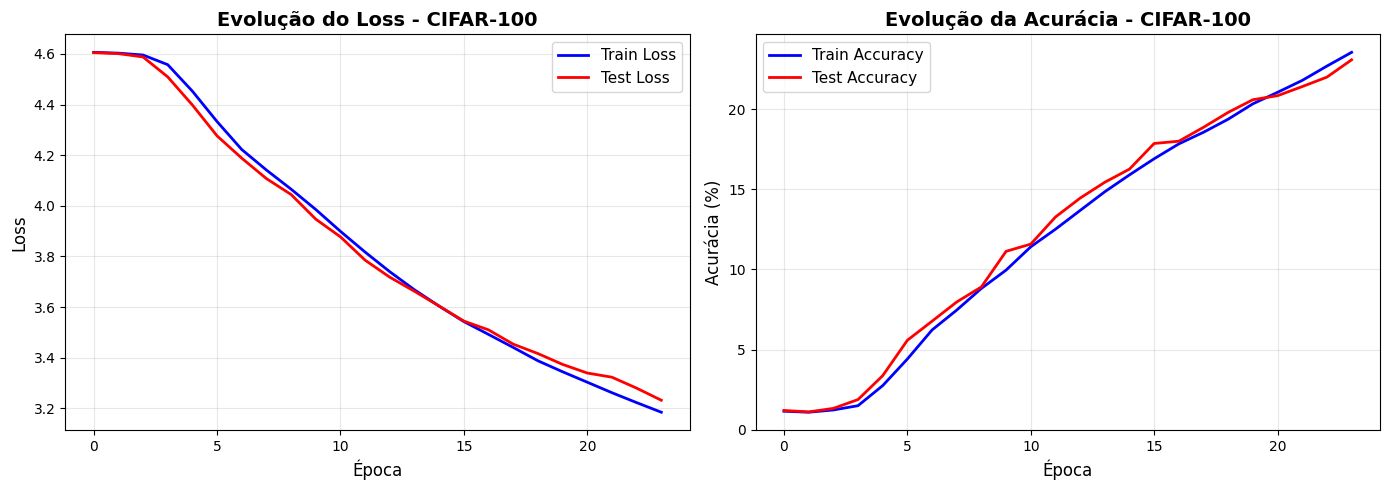


✅ Gráficos de métricas gerados com sucesso!


In [6]:
# ==== VISUALIZAÇÃO DE MÉTRICAS ====
# Plotar gráficos de Loss e Accuracy ao longo das épocas

plt.figure(figsize=(14, 5))

# Gráfico de Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Train Loss', linewidth=2)
plt.plot(test_losses, 'r-', label='Test Loss', linewidth=2)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Evolução do Loss - CIFAR-100', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Gráfico de Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'b-', label='Train Accuracy', linewidth=2)
plt.plot(test_accuracies, 'r-', label='Test Accuracy', linewidth=2)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Acurácia (%)', fontsize=12)
plt.title('Evolução da Acurácia - CIFAR-100', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'\n✅ Gráficos de métricas gerados com sucesso!')

In [7]:
# ==== IMPLEMENTAÇÃO DE HOOKS ====
# Hooks permitem capturar ativações intermediárias das camadas

# Dicionário para armazenar ativações
activations = {}

# Função hook que será chamada durante forward pass
def get_activation(name):
    def hook(model, input, output):
        # Armazena a saída (ativação) da camada
        activations[name] = output.detach()
    return hook

# Registrar hooks em todas as camadas convolucionais e de pooling
model[0].register_forward_hook(get_activation('conv1'))
model[1].register_forward_hook(get_activation('relu1'))
model[2].register_forward_hook(get_activation('pool1'))
model[3].register_forward_hook(get_activation('conv2'))
model[4].register_forward_hook(get_activation('relu2'))
model[5].register_forward_hook(get_activation('pool2'))

# Pegar uma imagem de teste para visualização
test_iter = iter(test_loader)
test_images, test_labels = next(test_iter)

# Passar imagem pelo modelo para capturar ativações
model.eval()
with torch.no_grad():
    test_images = test_images.to(device)
    output = model(test_images)

print(f'✅ Hooks registrados e ativações capturadas!')
print(f'   - Camadas: {list(activations.keys())}')


✅ Hooks registrados e ativações capturadas!
   - Camadas: ['conv1', 'relu1', 'pool1', 'conv2', 'relu2', 'pool2']


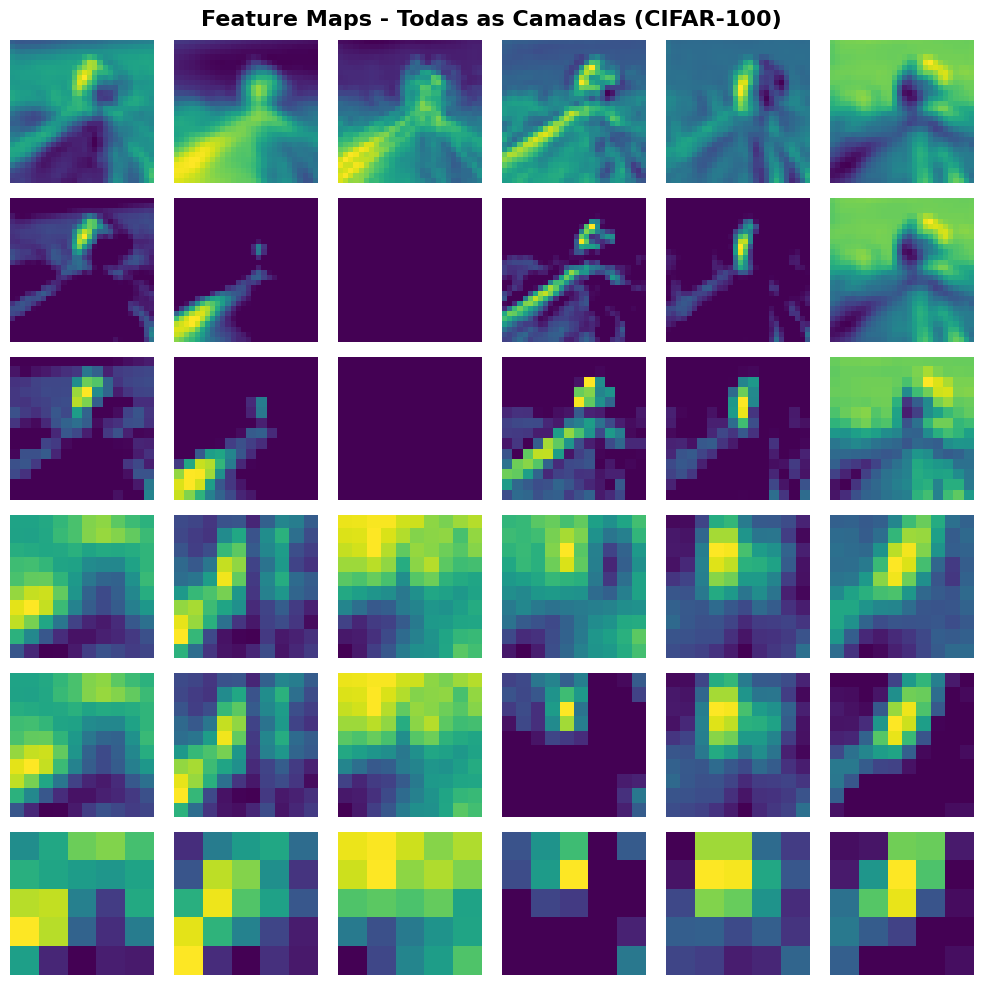


✅ Feature maps visualizados com sucesso!
   - 6 camadas x 6 filtros cada = 36 visualizações


In [10]:
# ==== VISUALIZAÇÃO DE FEATURE MAPS ====
# Visualizar ativações de todas as camadas

# Selecionar primeira imagem do batch
img_idx = 0

fig, axes = plt.subplots(6, 6, figsize=(10, 10))
fig.suptitle('Feature Maps - Todas as Camadas (CIFAR-100)', fontsize=16, fontweight='bold')

layers_to_plot = ['conv1', 'relu1', 'pool1', 'conv2', 'relu2', 'pool2']
start_row = 0

for layer_name in layers_to_plot:
    layer_activation = activations[layer_name][img_idx].cpu()
    num_features = min(6, layer_activation.shape[0])  # Max 6 filtros por camada

    for i in range(num_features):
        ax = axes[start_row, i]
        ax.imshow(layer_activation[i], cmap='viridis')
        if i == 0:
            ax.set_ylabel(f'{layer_name}\n{layer_activation.shape[1]}x{layer_activation.shape[2]}',
                         fontsize=10, fontweight='bold')
        ax.axis('off')

    start_row += 1

plt.tight_layout()
plt.show()

print(f'\n✅ Feature maps visualizados com sucesso!')
print(f'   - 6 camadas x 6 filtros cada = 36 visualizações')


# Análise Final

A LeNet-5 adaptada para o CIFAR-100 mostrou uma evolução constante durante as 24 épocas de treinamento, saindo de cerca de 4% para 23% de acurácia no teste. Esse resultado é considerado normal para esse tipo de rede, porque o CIFAR-100 é um conjunto de dados muito difícil, com 100 categorias diferentes e muitas imagens parecidas entre si. As curvas de erro mostram que o modelo foi aprendendo aos poucos, com apenas um leve sinal de overfitting, e ainda tinha espaço para melhorar se o treinamento continuasse.

A análise dos feature maps ajudou a entender como a rede “enxerga” as imagens: nas primeiras camadas, ela identifica formas simples como bordas e cores, e nas camadas seguintes começa a captar padrões mais complexos. Mesmo funcionando bem, a LeNet-5 é uma rede pequena e não tem capacidade suficiente para lidar plenamente com a complexidade do CIFAR-100. No geral, o experimento mostrou que a rede funciona corretamente, mas também deixou claro que tarefas mais difíceis exigem arquiteturas mais avançadas.

